In [1]:
__license__ = """
Copyright (c) 2012 mpldatacursor developers

Permission is hereby granted, free of charge, to any person obtaining a copy of
this software and associated documentation files (the "Software"), to deal in
the Software without restriction, including without limitation the rights to
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies
of the Software, and to permit persons to whom the Software is furnished to do
so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
"""

# pylint: skip-file
import itertools
import copy
import numpy as np
import matplotlib.transforms as mtransforms
import matplotlib.dates as mdates
from matplotlib import offsetbox
from mpl_toolkits import mplot3d

from matplotlib.contour import ContourSet
from matplotlib.image import AxesImage
from matplotlib.collections import PathCollection, LineCollection
from matplotlib.collections import PatchCollection, PolyCollection, QuadMesh
from matplotlib.container import Container
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from matplotlib.ticker import ScalarFormatter
from matplotlib.backend_bases import PickEvent


class DataCursor(object):
    """A simple data cursor widget that displays the x,y location of a
    matplotlib artist in an annotation box when the artist is clicked on."""

    default_annotation_kwargs = dict(
        xy=(0, 0), xytext=(-15, 15), textcoords='offset points', picker=True,
        bbox=dict(
            boxstyle='round,pad=.5', fc='yellow', alpha=.5, edgecolor='black'),
        arrowprops=dict(
            arrowstyle='->', connectionstyle='arc3', shrinkB=0,
            edgecolor='black')
    )

    default_keybindings = {'hide': 'd', 'toggle': 't',
                           'next': 'shift+right', 'previous': 'shift+left'}

    def __init__(self, artists, tolerance=5, formatter=None, point_labels=None,
                 display='one-per-axes', draggable=False, hover=False,
                 props_override=None, keybindings=True, date_format='%x %X',
                 display_button=1, hide_button=3, keep_inside=True,
                 **kwargs):
        """Create the data cursor and connect it to the relevant figure.

        Parameters
        -----------
        artists : a matplotlib artist or sequence of artists.
            The artists to make selectable and display information for.
        tolerance : number, optional
            The radius (in points) that the mouse click must be within to
            select the artist.
        formatter : function, optional
            A function that accepts arbitrary kwargs and returns a string that
            will be displayed with annotate. The `x`, `y`, `event`, `ind`, and
            `label` kwargs will always be present. See the
            ``mpldatacursor.datacursor`` function docstring for more
            information.
        point_labels : sequence or dict, optional
            Labels for "subitems" of an artist, passed to the formatter
            function as the `point_label` kwarg.  May be either a single
            sequence (used for all artists) or a dict of artist:sequence pairs.
        display : {'one-per-axes', 'single', 'multiple'}, optional
            Controls whether more than one annotation box will be shown.
        draggable : boolean, optional
            Controls whether or not the annotation box will be interactively
            draggable to a new location after being displayed. Default: False.
        hover : boolean, optional
            If True, the datacursor will "pop up" when the mouse hovers over an
            artist.  Defaults to False.  Enabling hover also sets
            `display="single"` and `draggable=False`.
        props_override : function, optional
            If specified, this function customizes the parameters passed into
            the formatter function and the x, y location that the datacursor
            "pop up" "points" to.  This is often useful to make the annotation
            "point" to a specific side or corner of an artist, regardless of
            the position clicked. The function is passed the same kwargs as the
            `formatter` function and is expected to return a dict with at least
            the keys "x" and "y" (and probably several others).
            Expected call signature: `props_dict = props_override(**kwargs)`
        keybindings : boolean or dict, optional
            By default, the keys "d" and "t" will be bound to hiding/showing
            all annotation boxes and toggling interactivity for datacursors,
            respectively.  "<shift> + <right>" and "<shift> + <left>" will be
            bound to moving the datacursor to the next and previous item in the
            sequence for artists that support it. If keybindings is False, the
            ability to hide/toggle datacursors interactively will be disabled.
            Alternatively, a dict mapping "hide", "toggle", "next", and
            "previous" to matplotlib key specifications may specified to
            customize the keyboard shortcuts.  Note that hitting the "hide" key
            once will hide datacursors, and hitting it again will show all of
            the hidden datacursors.
        date_format : string, optional
            The strftime-style formatting string for dates. Used only if the x
            or y axes have been set to display dates. Defaults to "%x %X".
        display_button: int, optional
            The mouse button that will triggers displaying an annotation box.
            Defaults to 1, for left-clicking. (Common options are
            1:left-click, 2:middle-click, 3:right-click)
        hide_button: int or None, optional
            The mouse button that triggers hiding the selected annotation box.
            Defaults to 3, for right-clicking. (Common options are
            1:left-click, 2:middle-click, 3:right-click, None:hiding disabled)
        keep_inside : boolean, optional
            Whether or not to adjust the x,y offset to keep the text box inside
            the figure. This option has no effect on draggable datacursors.
            Defaults to True. Note: Currently disabled on OSX and
            NbAgg/notebook backends.
        **kwargs : additional keyword arguments, optional
            Additional keyword arguments are passed on to annotate.
        """

        def filter_artists(artists):
            """Replace ContourSets, etc with their constituent artists."""
            output = []
            for item in artists:
                if isinstance(item, ContourSet):
                    output += item.collections
                elif isinstance(item, Container):
                    children = item.get_children()
                    for child in children:
                        child._mpldatacursor_label = item.get_label()
                        child._mpldatacursor_parent = item
                    output += children
                else:
                    output.append(item)
            return output

        if not np.iterable(artists):
            artists = [artists]

        # -- Deal with contour sets... -------------------------------------
        # These are particularly difficult, as the original z-value array
        # is never associated with the ContourSet, and they're not "normal"
        # artists (they're not actually added to the axes). Not only that, but
        # the PatchCollections created by filled contours don't even fire a
        # pick event for points inside them, only on their edges. At any rate,
        # this is a somewhat hackish way of handling contours, but it works.
        self.artists = filter_artists(artists)
        self.contour_levels = {}
        for cs in [x for x in artists if isinstance(x, ContourSet)]:
            for z, artist in zip(cs.levels, cs.collections):
                self.contour_levels[artist] = z

        valid_display_options = ['single', 'one-per-axes', 'multiple']
        if display in valid_display_options:
            self.display = display
        else:
            raise ValueError('"display" must be one of the following: ' \
                             ', '.join(valid_display_options))
        self.hover = hover
        if self.hover:
            self.display = 'single'
            self.draggable = False

        self.keep_inside = keep_inside
        self.tolerance = tolerance
        self.point_labels = point_labels
        self.draggable = draggable
        self.date_format = date_format
        self.props_override = props_override
        self.display_button = display_button
        self.hide_button = hide_button
        self.axes = tuple(set(art.axes for art in self.artists))
        self.figures = tuple(set(ax.figure for ax in self.axes))
        self._mplformatter = ScalarFormatter(useOffset=False, useMathText=True)
        self._hidden = False
        self._last_event = None
        self._last_annotation = None

        if self.draggable:
            # If we're dealing with draggable cursors, don't try to override
            # the x,y position.  Otherwise, dragging the cursor outside the
            # figure will have unexpected consequences.
            self.keep_inside = False

        if formatter is None:
            self.formatter = self._formatter
        else:
            self.formatter = formatter

        self._annotation_kwargs = kwargs
        self.annotations = {}
        if self.display != 'multiple':
            for ax in self.axes:
                self.annotations[ax] = self.annotate(ax, **kwargs)
                # Hide the annotation box until clicked...
                self.annotations[ax].set_visible(False)

        if keybindings:
            if keybindings is True:
                self.keybindings = self.default_keybindings
            else:
                self.keybindings = self.default_keybindings.copy()
                self.keybindings.update(keybindings)
            for fig in self.figures:
                fig.canvas.mpl_connect('key_press_event', self._on_keypress)

        self.enable()

        # We need to make sure the DataCursor isn't garbage collected until the
        # figure is.  Matplotlib's weak references won't keep this DataCursor
        # instance alive in all cases.
        for fig in self.figures:
            try:
                fig._mpldatacursors.append(self)
            except AttributeError:
                fig._mpldatacursors = [self]

    def __call__(self, event):
        """Create or update annotations for the given event. (This is intended
        to be a callback connected to matplotlib's pick event.)"""
        # Need to refactor self._select and this function. The separation is
        # purely for historical reasons and could be simplified significantly.

        if not self._event_ignored(event):
            self._show_annotation_box(event)

    def _event_ignored(self, event):
        """Decide whether or not to ignore a click/hover event."""
        # Ignore if another action (zoom, pan) is active
        if event.canvas.widgetlock.locked():
            return True

        # Ignore non-hiding pick events for the annotation box itself
        # (otherwise, draggable annotation boxes won't work) and pick
        # events not for the artists that this data cursor manages.
        if event.artist not in self.artists:
            return True

        if not self.hover:
            # Ignore pick events from other mouse buttons
            if event.mouseevent.button != self.display_button:
                return True

        return False

    def _show_annotation_box(self, event):
        """Update an existing box or create an annotation box for an event."""
        ax = event.artist.axes
        # Get the pre-created annotation box for the axes or create a new one.
        if self.display != 'multiple':
            annotation = self.annotations[ax]
        elif event.mouseevent in self.annotations:
            # Avoid creating multiple datacursors for the same click event
            # when several artists are selected.
            annotation = self.annotations[event.mouseevent]
        else:
            annotation = self.annotate(ax, **self._annotation_kwargs)
            self.annotations[event.mouseevent] = annotation

        if self.display == 'single':
            # Hide any other annotation boxes...
            for ann in self.annotations.values():
                ann.set_visible(False)

        self.update(event, annotation)

    def event_info(self, event):
        """Get a dict of info for the artist selected by "event"."""

        def default_func(event):
            return {}

        registry = {
            AxesImage: [image_props],
            PathCollection: [scatter_props, self._contour_info,
                             collection_props],
            Line2D: [line_props, errorbar_props],
            LineCollection: [collection_props,
                             self._contour_info,
                             errorbar_props],
            PatchCollection: [collection_props,
                              self._contour_info],
            PolyCollection: [collection_props,
                             scatter_props],
            QuadMesh: [collection_props],
            Rectangle: [rectangle_props],
        }
        x, y = event.mouseevent.xdata, event.mouseevent.ydata
        props = dict(x=x, y=y, label=event.artist.get_label(), event=event)
        props['ind'] = getattr(event, 'ind', None)
        props['point_label'] = self._point_label(event)

        funcs = registry.get(type(event.artist), [default_func])

        # 3D artist don't share inheritance. Fall back to naming convention.
        if '3D' in type(event.artist).__name__:
            funcs += [three_dim_props]

        for func in funcs:
            props.update(func(event))

        return props

    def _point_label(self, event):
        ind = getattr(event, 'ind', None)
        try:
            return [self.point_labels[i] for i in ind]
        except KeyError:
            # Assume self.point_labels is a dict of artist, sequence
            if event.artist in self.point_labels:
                return [self.point_labels[event.artist][i] for i in ind]
        except:
            return None

    def _contour_info(self, event):
        """Get the z-value for a pick event on an artists in a contour set."""
        return {'z': self.contour_levels.get(event.artist, None)}

    def _formatter(self, x=None, y=None, z=None, s=None, label=None, **kwargs):
        """
        Default formatter function, if no `formatter` kwarg is specified. Takes
        information about the pick event as a series of kwargs and returns the
        string to be displayed.
        """

        def is_date(axis):
            fmt = axis.get_major_formatter()
            return (isinstance(fmt, mdates.DateFormatter)
                    or isinstance(fmt, mdates.AutoDateFormatter))

        def format_date(num):
            if num is not None:
                return mdates.num2date(num).strftime(self.date_format)

        ax = kwargs['event'].artist.axes

        # Display x and y with range-specific formatting
        if is_date(ax.xaxis):
            x = format_date(x)
        else:
            limits = ax.get_xlim()
            x = self._format_coord(x, ax.xaxis)
            kwargs['xerror'] = self._format_coord(kwargs.get('xerror'), ax.xaxis)

        if is_date(ax.yaxis):
            y = format_date(y)
        else:
            limits = ax.get_ylim()
            y = self._format_coord(y, ax.yaxis)
            kwargs['yerror'] = self._format_coord(kwargs.get('yerror'), ax.yaxis)

        output = []
        for key, val in zip(['x', 'y', 'z', 's'], [x, y, z, s]):
            if val is not None:
                try:
                    output.append(u'{key}: {val:0.3g}'.format(key=key, val=val))
                except ValueError:
                    # X & Y will be strings at this point.
                    # For masked arrays, etc, "z" and s values may be a string
                    output.append(u'{key}: {val}'.format(key=key, val=val))

        # label may be None or an empty string (for an un-labeled AxesImage)...
        # Un-labeled Line2D's will have labels that start with an underscore
        if label and not label.startswith('_'):
            output.append(u'Label: {}'.format(label))

        if kwargs.get(u'point_label', None) is not None:
            output.append(u'Point: ' + u', '.join(kwargs['point_label']))

        for arg in ['xerror', 'yerror']:
            val = kwargs.get(arg, None)
            if val is not None:
                output.append(u'{}: {}'.format(arg, val))

        return u'\n'.join(output)

    def _format_coord(self, x, axis):
        """
        Handles display-range-specific formatting for the x and y coords.

        Parameters
        ----------
        x : number
            The number to be formatted
        axis : matplotlib.axis.Axis
            The Axis instance that we're working with (e.g. ax.xaxis, etc)
        """
        if x is None:
            return None

        limits = axis.get_view_interval()
        formatter = self._mplformatter
        # Trick the formatter into thinking we have an axes
        # The 7 tick locations is arbitrary but gives a reasonable detail level
        formatter.locs = np.linspace(limits[0], limits[1], 7)

        try:
            # Older versions of mpl
            formatter._set_orderOfMagnitude(abs(np.diff(limits)))
            formatter._set_format(*limits)
        except (AttributeError, TypeError):
            # 3.1.1 or later
            formatter.axis = axis
            formatter._set_format()
            formatter._set_order_of_magnitude()

        try:
            # Again, older versions of mpl
            return formatter.pprint_val(x)
        except AttributeError:
            # 3.3.0 or later
            return formatter.format_data_short(x)

    def annotate(self, ax, **kwargs):
        """
        Draws the annotation box for the given axis *ax*. Additional kwargs
        are passed on to ``annotate``.
        """

        def update_from_defaults(key, kwargs):
            if kwargs.get(key, None) is not None:
                new = copy.deepcopy(self.default_annotation_kwargs[key])
                new.update(kwargs[key])
                kwargs[key] = new
            return kwargs

        # Ensure bbox and arrowstyle params passed in use the defaults for
        # DataCursor. This allows things like ``bbox=dict(alpha=1)`` to show a
        # yellow, rounded box, instead of the mpl default blue, square box.)
        kwargs = update_from_defaults('bbox', kwargs)
        kwargs = update_from_defaults('arrowstyle', kwargs)

        # Set defaults where approriate.
        for key in self.default_annotation_kwargs:
            if key not in kwargs:
                kwargs[key] = self.default_annotation_kwargs[key]

        annotation = ax.annotate('This text will be reset', **kwargs)
        annotation._has_been_shown = False

        # Place the annotation in the figure instead of the axes so that it
        # doesn't get hidden behind other subplots (zorder won't fix that).
        ax.figure.texts.append(ax.texts[0])
        ax.texts[0].remove()

        # Create a draggable annotation box, if required.
        if self.draggable:
            offsetbox.DraggableAnnotation(annotation)

        # Save whether or not alignment is user-specified. If not, adjust to
        # match text offset (and update when display moves out of figure).
        self._user_set_ha = 'ha' in kwargs or 'horizontalalignment' in kwargs
        self._user_set_va = 'va' in kwargs or 'verticalalignment' in kwargs
        self._adjust_alignment(annotation)

        return annotation

    def _adjust_alignment(self, annotation):
        """
        Make text alignment match the specified offsets (this allows easier
        changing of relative position of text box...)
        """
        try:
            # annotation.xytext is depreciated in recent versions
            dx, dy = annotation.xyann
        except AttributeError:
            # but xyann doesn't exist in older versions...
            dx, dy = annotation.xytext

        horizontal = {1: 'left', 0: 'center', -1: 'right'}[np.sign(dx)]
        vertical = {1: 'bottom', 0: 'center', -1: 'top'}[np.sign(dy)]
        if not self._user_set_ha:
            annotation.set_horizontalalignment(horizontal)
        if not self._user_set_va:
            annotation.set_verticalalignment(vertical)

    def hide(self):
        """Hides all annotation artists associated with the DataCursor. Returns
        self to allow "chaining". (e.g. ``datacursor.hide().disable()``)"""
        self._hidden = True
        for artist in self.annotations.values():
            artist.set_visible(False)
        for fig in self.figures:
            fig.canvas.draw()
        return self

    def show(self):
        """Display all hidden data cursors. Returns self to allow chaining."""
        self._hidden = False
        for artist in self.annotations.values():
            if artist._has_been_shown:
                artist.set_visible(True)
        for fig in self.figures:
            fig.canvas.draw()
        return self

    def _hide_box(self, annotation):
        """Remove a specific annotation box."""
        annotation.set_visible(False)

        if self.display == 'multiple':
            annotation.axes.figure.texts.remove(annotation)
            # Remove the annotation from self.annotations.
            lookup = dict((self.annotations[k], k) for k in self.annotations)
            del self.annotations[lookup[annotation]]

        annotation.figure.canvas.draw()

    def disable(self):
        """
        Disconnects all callbacks and disables interactivity. Any existing
        annotations will continue to be visible (and draggable, if applicable).
        This has no effect if the datacursor has not been enabled. Returns self
        to allow "chaining". (e.g. ``datacursor.hide().disable()``)
        """
        if self._enabled:
            for fig, cids in self._cids:
                for cid in cids:
                    fig.canvas.mpl_disconnect(cid)
            self._enabled = False
        return self

    def enable(self):
        """Connects callbacks and makes artists pickable. If the datacursor has
        already been enabled, this function has no effect."""

        def connect(fig):
            if self.hover:
                event = 'motion_notify_event'
            else:
                event = 'button_press_event'
            cids = [fig.canvas.mpl_connect(event, self._select)]

            # None of this should be necessary. Workaround for a bug in some
            # mpl versions
            try:
                proxy = fig.canvas.callbacks.BoundMethodProxy(self)
                fig.canvas.callbacks.callbacks[event][cids[-1]] = proxy
            except AttributeError:
                # In some versions of mpl, BoundMethodProxy doesn't exist...
                # See: https://github.com/joferkington/mpldatacursor/issues/2
                pass
            return cids

        if not getattr(self, '_enabled', False):
            self._cids = [(fig, connect(fig)) for fig in self.figures]
            self._enabled = True
            try:
                # Newer versions of MPL use set_pickradius
                for artist in self.artists:
                    artist.set_pickradius(self.tolerance)
            except AttributeError:
                # Older versions of MPL control pick radius through set_picker
                for artist in self.artists:
                    artist.set_picker(self.tolerance)

        return self

    def _set_enabled(self, value):
        if value:
            self.enable()
        else:
            self.disable()

    enabled = property(lambda self: self._enabled, _set_enabled,
                       doc="The interactive state of the datacursor")

    def update(self, event, annotation):
        """Update the specified annotation."""
        # Get artist-specific information about the pick event
        info = self.event_info(event)

        if self.props_override is not None:
            info = self.props_override(**info)

        # Update the xy position and text using the formatter function
        annotation.set_text(self.formatter(**info))
        annotation.xy = info['x'], info['y']

        # Unfortnately, 3D artists are a bit more complex...
        # Also, 3D artists don't share inheritance. Use naming instead.
        if '3D' in type(event.artist).__name__:
            annotation.xy = event.mouseevent.xdata, event.mouseevent.ydata

        # In case it's been hidden earlier...
        annotation.set_visible(True)

        if self.keep_inside:
            self._keep_annotation_inside(annotation)

        annotation._has_been_shown = True
        self._last_event = event
        self._last_annotation = annotation

        event.canvas.draw()

    def _keep_annotation_inside(self, anno):
        fig = anno.figure

        # Need to draw the annotation to get the correct extent
        try:
            anno.draw(fig.canvas.renderer)
        except (AttributeError, RuntimeError):
            # Can't draw properly on OSX and NbAgg backends. Disable keep_inside
            return
        bbox = anno.get_window_extent()

        inside = [fig.bbox.contains(*corner) for corner in bbox.corners()]
        if all(inside):
            return

        outside = [not x for x in inside]
        xsign, ysign = 1, 1

        if outside[0] or outside[1]:
            xsign = -1
        if outside[2] or outside[3]:
            ysign = -1

        try:
            # annotation.xytext is depreciated
            dx, dy = anno.xyann
            anno.xyann = xsign * dx, ysign * dy
        except AttributeError:
            # but annotation.xyann doesn't exist in older mpl versions.
            dx, dy = anno.xytext
            anno.xytext = xsign * dx, ysign * dy

        self._adjust_alignment(anno)

    def _on_keypress(self, event):
        if event.key == self.keybindings['hide']:
            if self._hidden:
                self.show()
            else:
                self.hide()

        elif event.key == self.keybindings['toggle']:
            self.enabled = not self.enabled

        elif event.key == self.keybindings['next']:
            self._increment_index(1)

        elif event.key == self.keybindings['previous']:
            self._increment_index(-1)

    def _increment_index(self, di=1):
        """
        Move the most recently displayed annotation to the next item in the
        series, if possible. If ``di`` is -1, move it to the previous item.
        """
        if self._last_event is None:
            return

        if not hasattr(self._last_event, 'ind'):
            return

        event = self._last_event
        xy = get_xy(event.artist)

        if xy is not None:
            x, y = xy
            i = (event.ind[0] + di) % len(x)
            event.ind = [i]
            event.mouseevent.xdata = x[i]
            event.mouseevent.ydata = y[i]

            self.update(event, self._last_annotation)

    def _select(self, event):
        """This is basically a proxy to trigger a pick event.  This function is
        connected to either a mouse motion or mouse button event (see
        "self.enable") depending on "self.hover". If we're over a point, it
        fires a pick event.

        This probably seems bizarre, but it's required for hover mode (no mouse
        click) and otherwise it's a workaround for picking artists in twinned
        or overlapping axes.

        Even if we're not in hover mode, pick events won't work properly for
        twinned axes.  Therefore, we manually go through all artists managed by
        this datacursor and fire a pick event if the mouse is over an a managed
        artist."""

        def event_axes_data(event, ax):
            """Creates a new event will have xdata and ydata based on *ax*."""
            # We need to redefine event.xdata and event.ydata for twinned axes
            # to work correctly
            point = event.x, event.y
            x, y = ax.transData.inverted().transform_point(point)
            event = copy.copy(event)
            event.xdata, event.ydata = x, y
            return event

        def contains(artist, event):
            """Need to ensure we don't trigger a pick event for axes in a
            different figure. Otherwise, picking on one figure will trigger a
            datacursor in another figure."""
            if event.canvas is artist.figure.canvas:
                return artist.contains(event)
            else:
                return False, {}

        # If we're on top of an annotation box, hide it if right-clicked or
        # do nothing if we're in draggable mode
        for anno in list(self.annotations.values()):
            fixed_event = event_axes_data(event, anno.axes)
            if contains(anno, fixed_event)[0]:
                if event.button == self.hide_button:
                    self._hide_box(anno)
                elif self.draggable:
                    return

        for artist in self.artists:
            fixed_event = event_axes_data(event, artist.axes)
            inside, info = contains(artist, fixed_event)
            if inside:
                fig = artist.figure
                new_event = PickEvent('pick_event', fig.canvas, fixed_event,
                                      artist, **info)
                self(new_event)

                # Only fire a single pick event for one mouseevent. Otherwise
                # we'll need timers, etc to avoid multiple calls
                break

        # Not hovering over anything...
        if self.hover:
            artists = itertools.chain(self.artists, self.annotations.values())
            over_something = [contains(artist, event)[0] for artist in artists]
            if not any(over_something):
                self.hide()


class HighlightingDataCursor(DataCursor):
    """A data cursor that highlights the selected Line2D artist."""

    def __init__(self, *args, **kwargs):
        """
        Accepts a series of artists to interactively highlight.

        Arguments are identical to ``DataCursor`` except for the following
        keyword arguments:

        Parameters
        ----------
        highlight_color : a valid color specifier (string or tuple), optional
            The color to set the highlighted artist to. Default: yellow
        highlight_width : number, optional
            The width of the highlighted artist. Default: 3
        """
        self.highlight_color = kwargs.pop('highlight_color', 'yellow')
        self.highlight_width = kwargs.pop('highlight_width', 3)
        DataCursor.__init__(self, *args, **kwargs)
        self.highlights = {}

    def update(self, event, annotation):
        """Update the specified annotation."""
        # Decide whether or not to hide previous highlights...
        for artist in self.highlights.values():
            if self.display == 'multiple':
                continue
            if self.display == 'one-per-axes':
                if event.artist.axes is not artist.axes:
                    continue
            artist.set_visible(False)
        self.show_highlight(event.artist)
        DataCursor.update(self, event, annotation)

    def show_highlight(self, artist):
        """Show or create a highlight for a givent artist."""
        # This is a separate method to make subclassing easier.
        if artist in self.highlights:
            self.highlights[artist].set_visible(True)
        else:
            self.highlights[artist] = self.create_highlight(artist)
        return self.highlights[artist]

    def create_highlight(self, artist):
        """Create a new highlight for the given artist."""
        highlight = copy.copy(artist)
        highlight.set(color=self.highlight_color, mec=self.highlight_color,
                      lw=self.highlight_width, mew=self.highlight_width)
        artist.axes.add_artist(highlight)
        return highlight


def _coords2index(im, x, y, inverted=False):
    """
    Converts data coordinates to index coordinates of the array.

    Parameters
    -----------
    im : An AxesImage instance
        The image artist to operation on
    x : number
        The x-coordinate in data coordinates.
    y : number
        The y-coordinate in data coordinates.
    inverted : bool, optional
        If True, convert index to data coordinates instead of data coordinates
        to index.

    Returns
    --------
    i, j : Index coordinates of the array associated with the image.
    """
    xmin, xmax, ymin, ymax = im.get_extent()
    if im.origin == 'upper':
        ymin, ymax = ymax, ymin
    data_extent = mtransforms.Bbox([[ymin, xmin], [ymax, xmax]])
    array_extent = mtransforms.Bbox([[0, 0], im.get_array().shape[:2]])
    trans = mtransforms.BboxTransformFrom(data_extent) + \
            mtransforms.BboxTransformTo(array_extent)

    if inverted:
        trans = trans.inverted()

    return trans.transform_point([y, x]).astype(int)


def image_props(event):
    """
    Get information for a pick event on an ``AxesImage`` artist. Returns a dict
    of "i" & "j" index values of the image for the point clicked, and "z": the
    (uninterpolated) value of the image at i,j.

    Parameters
    -----------
    event : PickEvent
        The pick event to process

    Returns
    --------
    props : dict
        A dict with keys: z, i, j
    """
    x, y = event.mouseevent.xdata, event.mouseevent.ydata
    i, j = _coords2index(event.artist, x, y)
    z = event.artist.get_array()[i, j]
    if z.size > 1:
        # Override default numpy formatting for this specific case. Bad idea?
        z = ', '.join('{:0.3g}'.format(item) for item in z)
    return dict(z=z, i=i, j=j)


def line_props(event):
    """
    Get information for a pick event on a Line2D artist (as created with
    ``plot``.)

    This will yield x and y values that are interpolated between vertices
    (instead of just being the position of the mouse) or snapped to the nearest
    vertex if only the vertices are drawn.

    Parameters
    -----------
    event : PickEvent
        The pick event to process

    Returns
    --------
    props : dict
        A dict with keys: x & y
    """
    xclick, yclick = event.mouseevent.xdata, event.mouseevent.ydata
    i = event.ind[0]
    xorig, yorig = event.artist.get_xydata().T

    # For points-only lines, snap to the nearest point.
    linestyle = event.artist.get_linestyle()
    if linestyle in ['none', ' ', '', None, 'None']:
        return dict(x=xorig[i], y=yorig[i])

    # ax.step is actually implemented as a Line2D with a different drawstyle...
    xs_data = xorig[max(i - 1, 0): i + 2]
    ys_data = yorig[max(i - 1, 0): i + 2]
    drawstyle = event.artist.drawStyles[event.artist.get_drawstyle()]
    if drawstyle == "_draw_lines":
        pass
    elif drawstyle == "_draw_steps_pre":
        xs_data = _interleave(xs_data, xs_data[:-1])
        ys_data = _interleave(ys_data, ys_data[1:])
    elif drawstyle == "_draw_steps_post":
        xs_data = _interleave(xs_data, xs_data[1:])
        ys_data = _interleave(ys_data, ys_data[:-1])
    elif drawstyle == "_draw_steps_mid":
        mid_xs = (xs_data[:-1] + xs_data[1:]) / 2
        xs_data = _interleave(xs_data, np.column_stack([mid_xs, mid_xs]))
        ys_data = _interleave(
            ys_data, np.column_stack([ys_data[:-1], ys_data[1:]]))
    else:
        raise ValueError(
            "Unknown drawstyle: {}".format(event.artist.get_drawstyle()))
    # The artist transform may be different from the axes transform (e.g.,
    # axvline/axhline)
    artist_transform = event.artist.get_transform()
    axes_transform = event.artist.axes.transData
    xs_screen, ys_screen = (
        artist_transform.transform(
            np.column_stack([xs_data, ys_data]))).T
    xclick_screen, yclick_screen = (
        axes_transform.transform([xclick, yclick]))
    x_screen, y_screen = _interpolate_line(xs_screen, ys_screen,
                                           xclick_screen, yclick_screen)
    x, y = axes_transform.inverted().transform([x_screen, y_screen])

    return dict(x=x, y=y)


def _interleave(a, b):
    """Interleave arrays a and b; b may have multiple columns and must be
    shorter by 1.
    """
    b = np.column_stack([b])  # Turn b into a column array.
    nx, ny = b.shape
    c = np.zeros((nx + 1, ny + 1))
    c[:, 0] = a
    c[:-1, 1:] = b
    return c.ravel()[:-(c.shape[1] - 1)]


def _interpolate_line(xorig, yorig, xclick, yclick):
    """Find the nearest point on a polyline segment to the point *xclick*
    *yclick*."""
    candidates = []
    # The closest point may be a vertex.
    for x, y in zip(xorig, yorig):
        candidates.append((np.hypot(xclick - x, yclick - y), (x, y)))
    # Or it may be a projection on a segment.
    for (x0, x1), (y0, y1) in zip(zip(xorig, xorig[1:]), zip(yorig, yorig[1:])):
        vec1 = np.array([x1 - x0, y1 - y0])
        vec1 /= np.linalg.norm(vec1)
        vec2 = np.array([xclick - x0, yclick - y0])
        dist_along = vec1.dot(vec2)
        x, y = np.array([x0, y0]) + dist_along * vec1
        # Drop if out of the segment.
        if (x - x0) * (x - x1) > 0 or (y - y0) * (y - y1) > 0:
            continue
        candidates.append((np.hypot(xclick - x, yclick - y), (x, y)))
    _, (x, y) = min(candidates)
    return x, y


def collection_props(event):
    """
    Get information for a pick event on an artist collection (e.g.
    LineCollection, PathCollection, PatchCollection, etc).  This will"""
    ind = event.ind[0]
    arr = event.artist.get_array()
    # If a constant color/c/z was specified, don't return it
    if arr is None or len(arr) == 1:
        z = None
    else:
        z = arr[ind]
    return dict(z=z, c=z)


def scatter_props(event):
    """
    Get information for a pick event on a PathCollection artist (usually
    created with ``scatter``).

    Parameters
    -----------
    event : PickEvent
        The pick event to process

    Returns
    --------
    A dict with keys:
        `c`: The value of the color array at the point clicked.
        `s`: The value of the size array at the point clicked.
        `z`: Identical to `c`. Specified for convenience.

    Notes
    -----
    If constant values were specified to ``c`` or ``s`` when calling
    ``scatter``, `c` and/or `z` will be ``None``.
    """
    # Use only the first item, if multiple items were selected
    ind = event.ind[0]

    try:
        sizes = event.artist.get_sizes()
    except AttributeError:
        sizes = None
    # If a constant size/s was specified, don't return it
    if sizes is None or len(sizes) == 1:
        s = None
    else:
        s = sizes[ind]

    try:
        # Snap to the x, y of the point... (assuming it's created by scatter)
        xorig, yorig = event.artist.get_offsets().T
        x, y = xorig[ind], yorig[ind]
        return dict(x=x, y=y, s=s)
    except IndexError:
        # Not created by scatter...
        return dict(s=s)


def errorbar_props(event):
    if hasattr(event.artist, '_mpldatacursor_parent'):
        container = event.artist._mpldatacursor_parent
    else:
        return {}

    if hasattr(event, 'ind') and event.ind is not None:
        i = event.ind[0]
    else:
        return {}

    xerr = yerr = [None] * i
    if container.has_yerr and container.has_xerr:
        xerr = _extract_xerr(container[2][0])
        yerr = _extract_yerr(container[2][1])
    elif container.has_yerr:
        xerr = _extract_xerr(container[2][0])
    elif container.has_xerr:
        yerr = _extract_xerr(container[2][0])

    x, y = container[0].get_xydata().T
    return {'xerror': xerr[i], 'yerror': yerr[i], 'x': x[i], 'y': y[i]}


def _extract_yerr(errbar_artist):
    segments = errbar_artist.get_segments()
    return [abs(np.diff(seg[:, 1])[0]) for seg in segments]


def _extract_xerr(errbar_artist):
    segments = errbar_artist.get_segments()
    return [abs(np.diff(seg[:, 0])[0]) for seg in segments]


def three_dim_props(event):
    """
    Get information for a pick event on a 3D artist.

    Parameters
    -----------
    event : PickEvent
        The pick event to process

    Returns
    --------
    A dict with keys:
        `x`: The estimated x-value of the click on the artist
        `y`: The estimated y-value of the click on the artist
        `z`: The estimated z-value of the click on the artist

    Notes
    -----
    Based on mpl_toolkits.axes3d.Axes3D.format_coord
    Many thanks to Ben Root for pointing this out!
    """
    ax = event.artist.axes
    if ax.M is None:
        return {}

    xd, yd = event.mouseevent.xdata, event.mouseevent.ydata
    p = (xd, yd)
    edges = ax.tunit_edges()
    ldists = [(mplot3d.proj3d.line2d_seg_dist(p0, p1, p), i) for \
              i, (p0, p1) in enumerate(edges)]
    ldists.sort()

    # nearest edge
    edgei = ldists[0][1]

    p0, p1 = edges[edgei]

    # scale the z value to match
    x0, y0, z0 = p0
    x1, y1, z1 = p1
    d0 = np.hypot(x0 - xd, y0 - yd)
    d1 = np.hypot(x1 - xd, y1 - yd)
    dt = d0 + d1
    z = d1 / dt * z0 + d0 / dt * z1

    x, y, z = mplot3d.proj3d.inv_transform(xd, yd, z, ax.M)
    return dict(x=x, y=y, z=z)


def rectangle_props(event):
    """
    Returns the width, height, left, and bottom of a rectangle artist.

    Parameters
    -----------
    event : PickEvent
        The pick event to process

    Returns
    --------
    A dict with keys:
        `width` : The width of the rectangle
        `height` : The height of the rectangle
        `left` : The minimum x-coordinate of the rectangle
        `right` : The maximum x-coordinate of the rectangle
        `bottom` : The minimum y-coordinate of the rectangle
        `top` : The maximum y-coordinate of the rectangle
        `xcenter` : The mean x-coordinate of the rectangle
        `ycenter` : The mean y-coordinate of the rectangle
        `label` : The label for the rectangle or None
    """
    artist = event.artist
    width, height = artist.get_width(), artist.get_height()
    left, bottom = artist.xy
    right, top = left + width, bottom + height
    xcenter = left + 0.5 * width
    ycenter = bottom + 0.5 * height

    label = artist.get_label()
    if label is None or label.startswith('_nolegend'):
        try:
            label = artist._mpldatacursor_label
        except AttributeError:
            label = None

    return dict(width=width, height=height, left=left, bottom=bottom,
                label=label, right=right, top=top,
                xcenter=xcenter, ycenter=ycenter)


def get_xy(artist):
    """
    Attempts to get the x,y data for individual items subitems of the artist.
    Returns None if this is not possible.

    At present, this only supports Line2D's and basic collections.
    """
    xy = None

    if hasattr(artist, 'get_offsets'):
        xy = artist.get_offsets().T
    elif hasattr(artist, 'get_xydata'):
        xy = artist.get_xydata().T

    return xy

In [2]:
"""
This module houses the extension HighlightingDataCursor class to support cluster
by cluster highlighting.
"""

import matplotlib.pyplot as plt

# Temporary solution, current version 0.7.1 is not compatible with matplotlib>=3.3.0

class IndexedHighlight(HighlightingDataCursor):
    """
    This class extends HighlightingDataCursor to add support for
    highlighting of cluster groups.
    """

    def __init__(self, axes, **kwargs):
        """
        Initializes the highlighting object for each AxesSubplot in a plot.
        """
        artists = axes

        kwargs['display'] = 'single'
        HighlightingDataCursor.__init__(self, artists, **kwargs)
        self.highlights = [self.create_highlight(artist) for artist in artists]
        plt.setp(self.highlights, visible=False)

    def update(self, event, annotation):
        """
        On each update event, this method will loop through all SubPlot objects
        and the group of points corresponding to the current selected object
        will be highlighted.
        """

        # Hide all other annotations
        plt.setp(self.highlights, visible=False)

        for i, artst in enumerate(self.artists):
            if event.artist is artst:
                self.highlights[i].set(visible=True)

        DataCursor.update(self, event, annotation)

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import warnings

# Get S&P 500 tickers from Wikipedia
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
table = pd.read_html(url)[0]
tickers = table["Symbol"].tolist()

start_date = "2020-01-01"
end_date = "2024-01-01"

warnings.simplefilter(action='ignore', category=FutureWarning) # Ignore FutureWarning from yfinance/pandas
data = yf.download(tickers, start=start_date, end=end_date)["Adj Close"]

[*********************100%%**********************]  503 of 503 completed


6 Failed downloads:
['SOLV', 'SW', 'GEV']: Exception("%ticker%: Data doesn't exist for startDate = 1577854800, endDate = 1704085200")
['HWM', 'BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2020-01-01 -> 2024-01-01)')
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [13]:
# Clean data
data = data.drop(columns=data.columns[np.isnan(data.iloc[0,:])|np.isnan(data.iloc[-1,:])])

# Compute and normalize daily returns
returns = data.pct_change().dropna()
returns = (returns-returns.mean())/returns.std()

# Perform PCA
pca = PCA(n_components=10)
pca.fit(returns)

PCA(n_components=10)

In [14]:
# Apply PCA to returns
principal_components = pd.DataFrame(pca.transform(returns))
#print(principal_components.shape,returns.shape)
#principal_components.columns = returns.columns

# Cluster with OPTICS
optics = OPTICS(min_samples=2)
clusters = optics.fit_predict(principal_components)

140
            0         1         2
860 -4.570432  2.128945  2.253128
880 -4.833237  2.077722  2.286939
            0         1         2
249 -3.002015  3.936334  1.364852
670 -3.075571  5.384027  1.595596
881 -3.427567  5.654380  1.322787
987 -3.181824  5.657578  2.123337
            0         1         2
446 -2.605812  5.059070  0.016102
904 -2.742207  5.033654 -0.197778
            0         1         2
224 -3.079901  3.634292  2.658925
265 -3.234640  3.515455  2.390149
838 -2.749522  3.426100  3.570943
            0         1         2
23  -0.162847  0.571940  1.262964
906 -0.317503  1.060448  0.936013
            0         1         2
841 -0.213537  1.879909  0.097236
864 -0.390492  1.774899  0.140299
            0         1         2
3    0.176236 -1.778271  1.145764
927 -0.160531 -1.706614  1.039303
             0         1         2
10   -1.147086 -2.455495  0.639707
820  -2.128727 -1.542679  1.122178
1003 -1.744544 -2.143225  0.769508
            0         1         2
247 -1

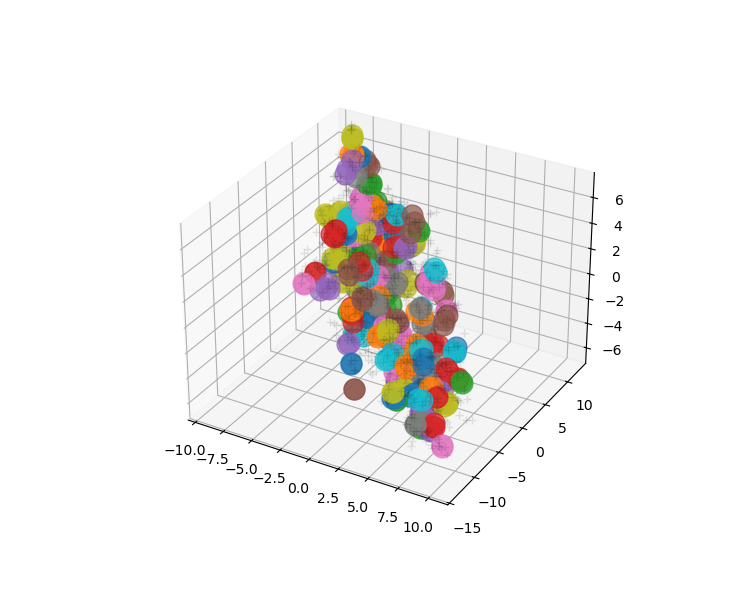

In [15]:
%matplotlib widget
no_of_classes = len(np.unique(optics.labels_))
print(no_of_classes)

fig = plt.figure(facecolor='white', figsize=(7.5,6))

tsne = TSNE(n_components=3, init='random')

tsne_df = pd.DataFrame(tsne.fit_transform(principal_components),
                       index=principal_components.index)

ax_object = plt.subplot(111, projection='3d')
paths_collection = []

# For each cluster.
for cluster in range(0, no_of_classes):
    # Get specific cluster data from the tsne processed dataframe.
    cluster_data = tsne_df[optics.labels_ == cluster]
    print(cluster_data)

    # Plot the cluster data by column index [0, 1, 2] -> [x, y, z].
    paths = ax_object.plot(cluster_data.loc[:, 0], cluster_data.loc[:, 1],
                           cluster_data.loc[:, 2], alpha=0.7, marker='.',
                           linestyle='None',
                           markersize=30)

    # Stash the list of Line2D objects for future use.
    paths_collection.append(paths)

# Flatten the paths array and instantiate the IndexedHighlight class
# that will manage the selection and highlighting of the plotted
# clusters.
IndexedHighlight(np.ravel(paths_collection),
                 formatter='{label}'.format)

# Plot the noisy samples which are not included in a leaf cluster labelled as -1,
# by column index [0, 1, 2] -> [x, y, z].
ax_object.plot(tsne_df.iloc[optics.labels_ == -1, 0], tsne_df.iloc[optics.labels_ == -1, 1],
               tsne_df.iloc[optics.labels_ == -1, 2], 'k+', alpha=0.1)

# Set the chart title.
# ax_object.set_title('Automatic Clustering\n' + method)

In [22]:
pca.fit(returns)

PCA(n_components=10)

In [24]:
pca.n_features_in_,pca.components_.shape,returns.shape,pca.transform(returns).shape

(490, (10, 490), (1005, 490), (1005, 10))